In [68]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Add, Conv2D, Input, Lambda
from tensorflow.keras.models import Model
from models.edsr import edsr
import matplotlib as plt
import seaborn as sns

In [69]:
def quantile_clipping(data, percentage, mode="max"):
    quantile_val = np.quantile(data, percentage)
    if mode == "max":
        data = data.clip(max=quantile_val)
    if mode == "min":
        data = data.clip(min=quantile_val)
    return data

def exp_root_norm(data, exp=2):
    return data ** (1 / exp)

def minmax_scale(images):
    # Assuming images is a 4D array with shape (N, 32, 32)
    min_val = np.min(images)
    max_val = np.max(images)
    
    scaled_images = (images - min_val) / (max_val - min_val)
    
    return scaled_images

def preprocess(images):
    images = quantile_clipping(images, 0.95, mode="max")
    images = exp_root_norm(images, exp=2)
    images = minmax_scale(images)
    return images

In [73]:

path_to_data = 'CNSM/data'
dataset = 'geant'
original_size = 22
ground_truth = f'{dataset}_original_{original_size}.npy'
# coarse_size = original_size // scale_factor
# train_file = f'{dataset}_coarse_{coarse_size}_x{scale_factor}.npy'
NUM_EPOCHS = 20

In [79]:
from tensorflow.keras.optimizers import Adam


for scale_factor in [6]:
    # Load your datasets
    coarse_size = original_size // scale_factor
    train_file = f'{dataset}_coarse_{coarse_size}_x{scale_factor}.npy'
    train_set = np.load(os.path.join(path_to_data, train_file))
    train_ground_truth = np.load(os.path.join(path_to_data, ground_truth))
    fine_matrix_size = original_size
    if train_set.shape[1]*scale_factor != train_ground_truth.shape[1]:
        fine_matrix_size = train_set.shape[1]*scale_factor
        train_ground_truth = train_ground_truth[:, :fine_matrix_size, :fine_matrix_size]

    # Reshape the data to add a channel dimension
    train_set = train_set.reshape((-1, coarse_size, coarse_size, 1))
    train_ground_truth = train_ground_truth.reshape((-1, fine_matrix_size ,fine_matrix_size, 1))

    # Preprocess tms
    train_set = preprocess(train_set)
    train_ground_truth = preprocess(train_ground_truth)

    # Split the data into train and test sets
    train_size = int(0.8 * len(train_set))
    x_train, x_test = train_set[:train_size], train_set[train_size:]
    y_train, y_test = train_ground_truth[:train_size], train_ground_truth[train_size:]

    # Create and compile the model
    model = edsr(scale=scale_factor, input_depth=1, num_filters=64, num_res_blocks=4)
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mse')

    # Train the model for one epoch
    model.fit(x_train, y_train, epochs=NUM_EPOCHS, batch_size=32, validation_split=0.2)

    # Save weights
    model.save_weights(f'CNSM/data/{dataset}_centr_results_x{scale_factor}_epochs_{NUM_EPOCHS}.h5')

    # Prediction

    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # Assuming you have already made predictions on the test set
    # and inverse-transformed both predictions and ground truth

    # Flatten the arrays to 1D for easier calculation
    test_predictions = model.predict(x_test)
    y_true = y_test.flatten()
    y_pred = test_predictions.flatten()

    # Calculate MSE
    mse = mean_squared_error(y_true, y_pred)

    # Calculate RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)

    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    # Optional: Calculate R-squared (coefficient of determination)
    from sklearn.metrics import r2_score
    r2 = r2_score(y_true, y_pred)
    print(f"R-squared: {r2:.4f}")

    # Save

    # Let's save the performance in a csv file
    import csv
    import os

    filename = f'CNSM/data/{dataset}_centr_results_x{scale_factor}_epochs_{NUM_EPOCHS}.csv'
    if not os.path.exists(filename):
        with open(filename, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["MSE", "RMSE", "MAE", "MAPE", "R2"])
            writer.writerow([mse, rmse, mae, mape, r2])

Epoch 1/20
230/230 [==============================] - 8s 23ms/step - loss: 0.0156 - val_loss: 0.0103
Epoch 2/20
230/230 [==============================] - 5s 21ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 3/20
230/230 [==============================] - 5s 21ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 4/20
230/230 [==============================] - 5s 21ms/step - loss: 0.0084 - val_loss: 0.0084
Epoch 5/20
230/230 [==============================] - 5s 21ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 6/20
230/230 [==============================] - 5s 21ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 7/20
230/230 [==============================] - 5s 21ms/step - loss: 0.0077 - val_loss: 0.0079
Epoch 8/20
230/230 [==============================] - 5s 21ms/step - loss: 0.0075 - val_loss: 0.0075
Epoch 9/20
230/230 [==============================] - 5s 21ms/step - loss: 0.0074 - val_loss: 0.0076
Epoch 10/20
230/230 [==============================] - 5s 21ms/step - loss: 0.0073 - val_lo

/tmp/ipykernel_100998/651648352.py:62: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


 6/72 [=>............................] - ETA: 0s

72/72 [==============================] - 1s 14ms/step


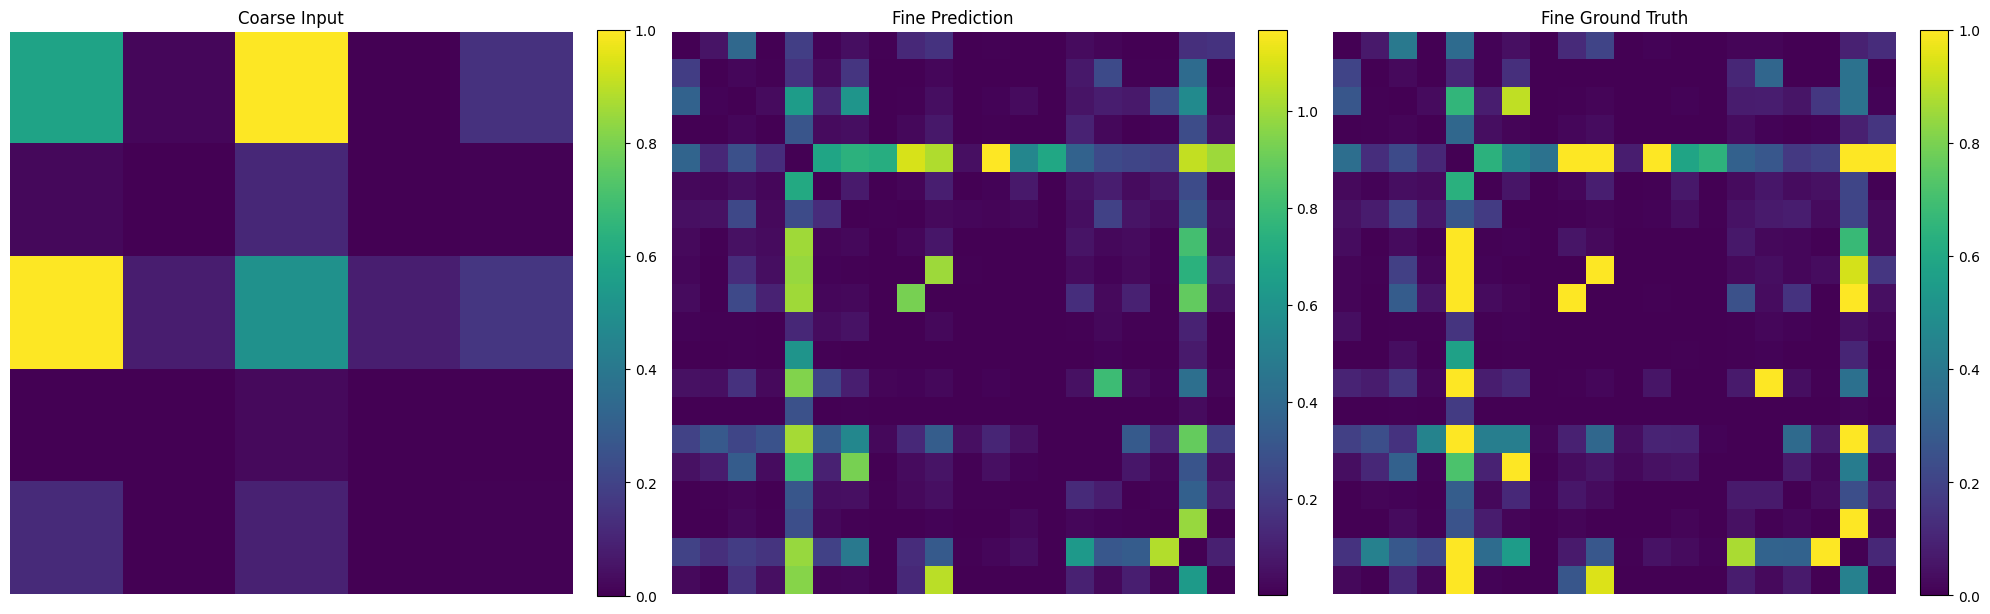

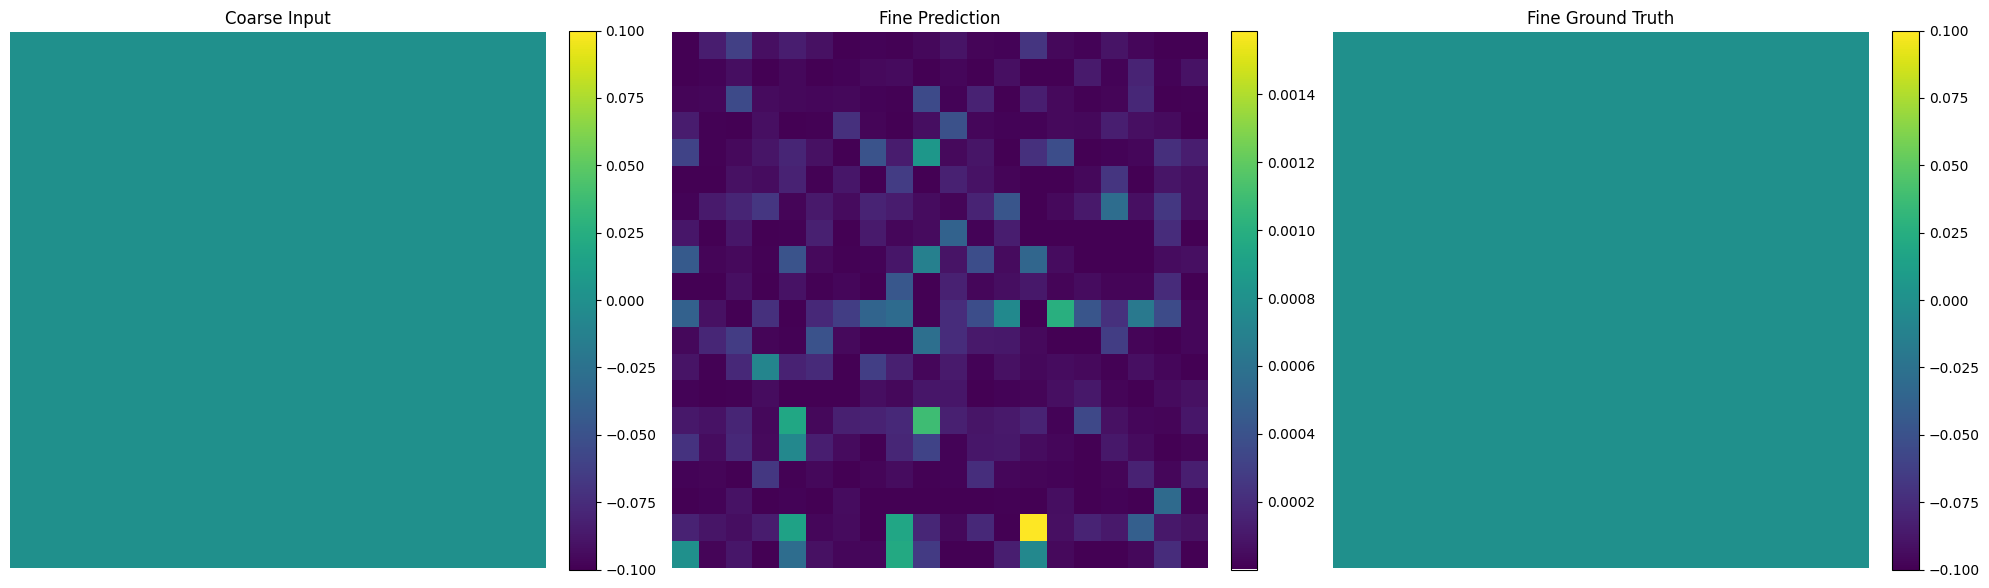

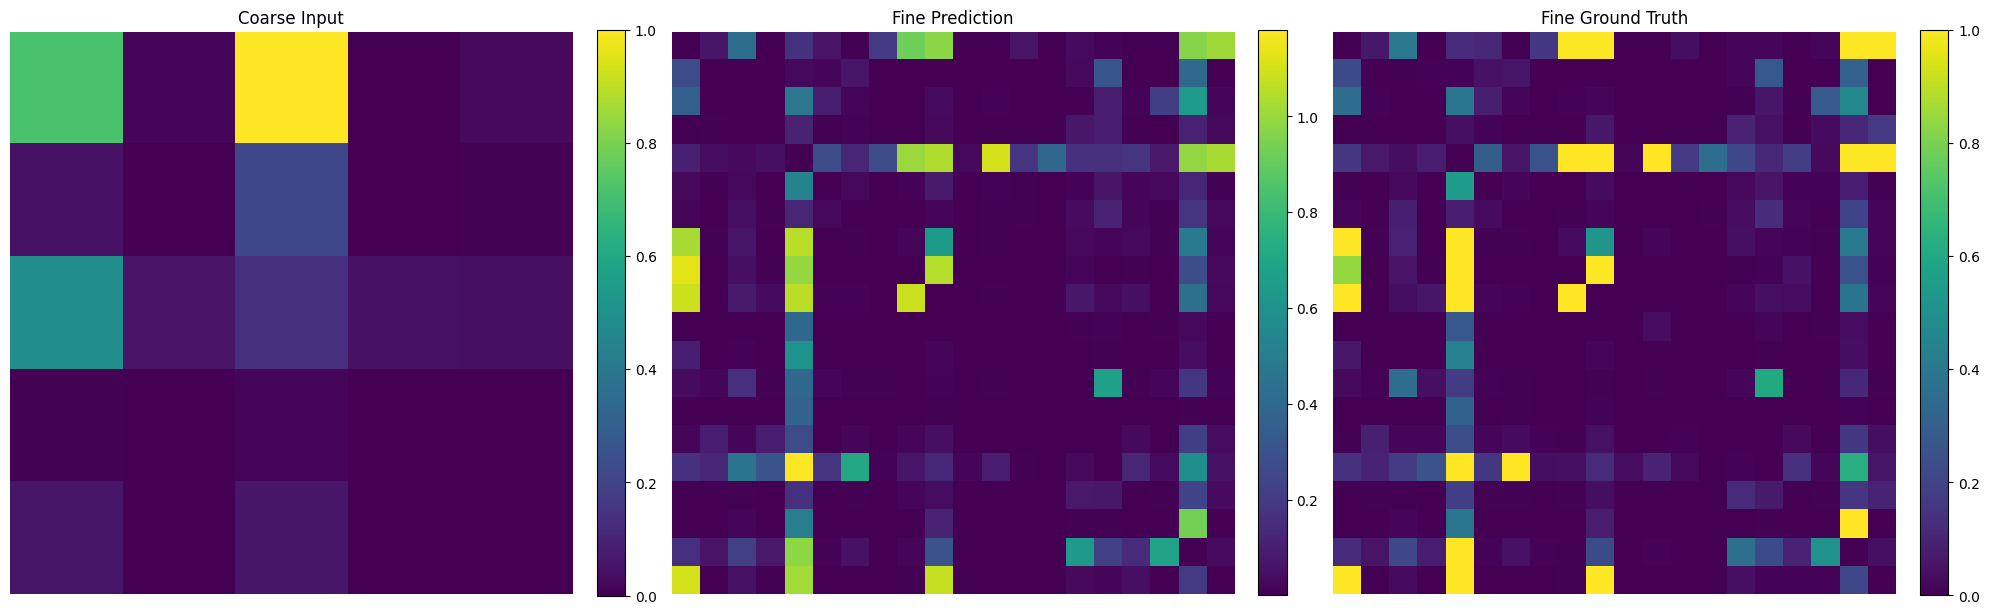

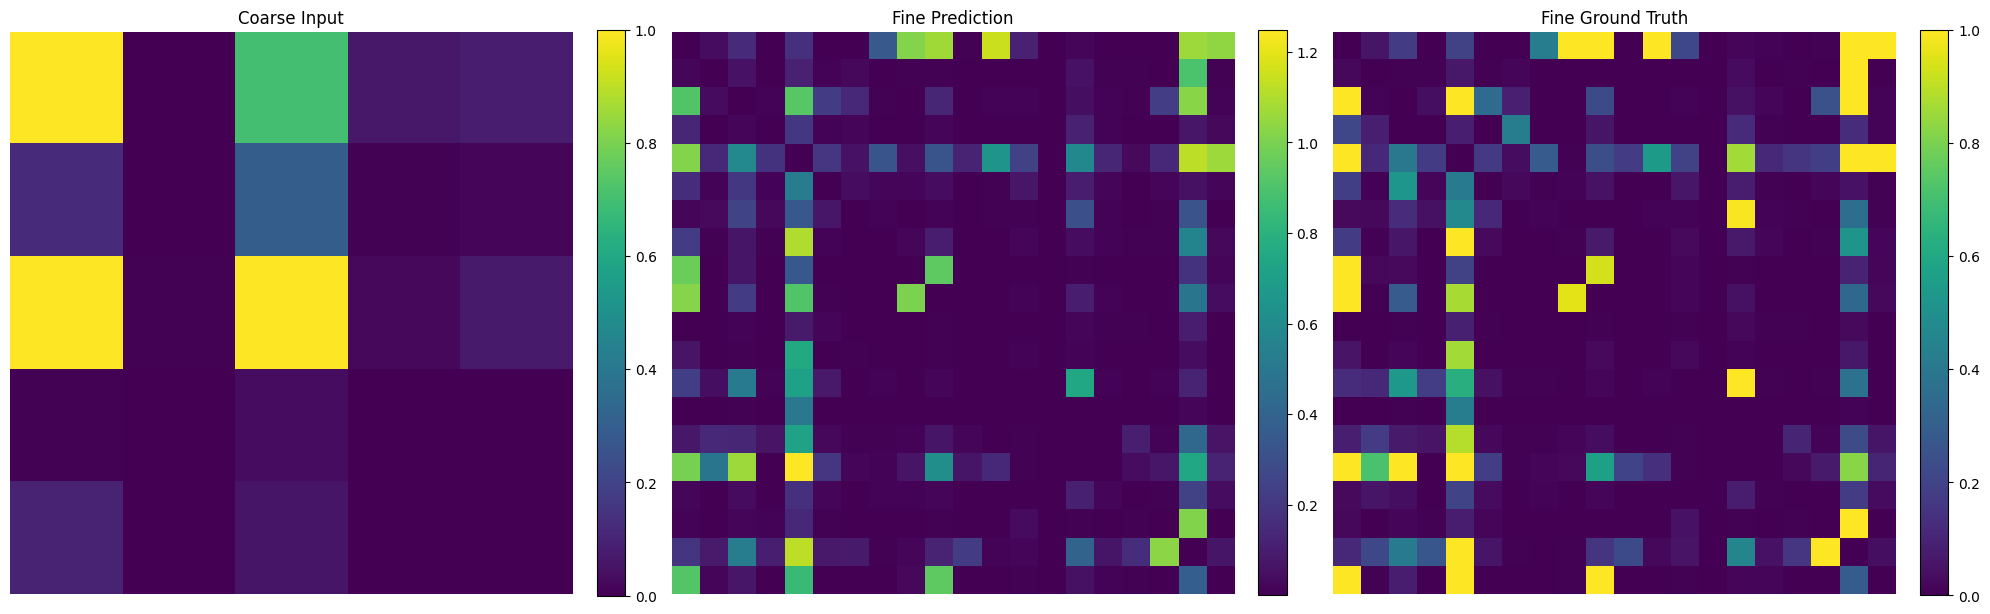

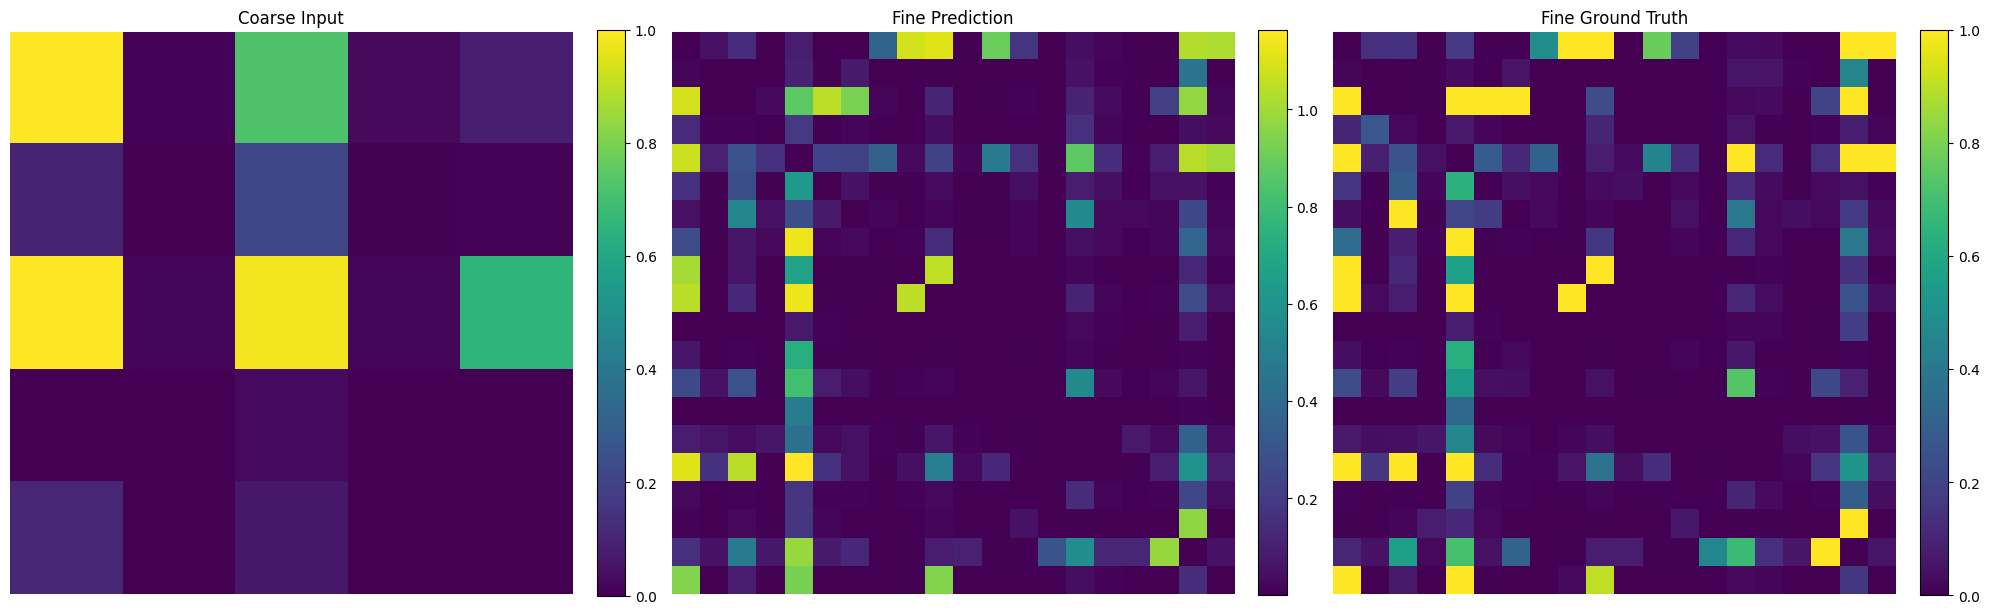

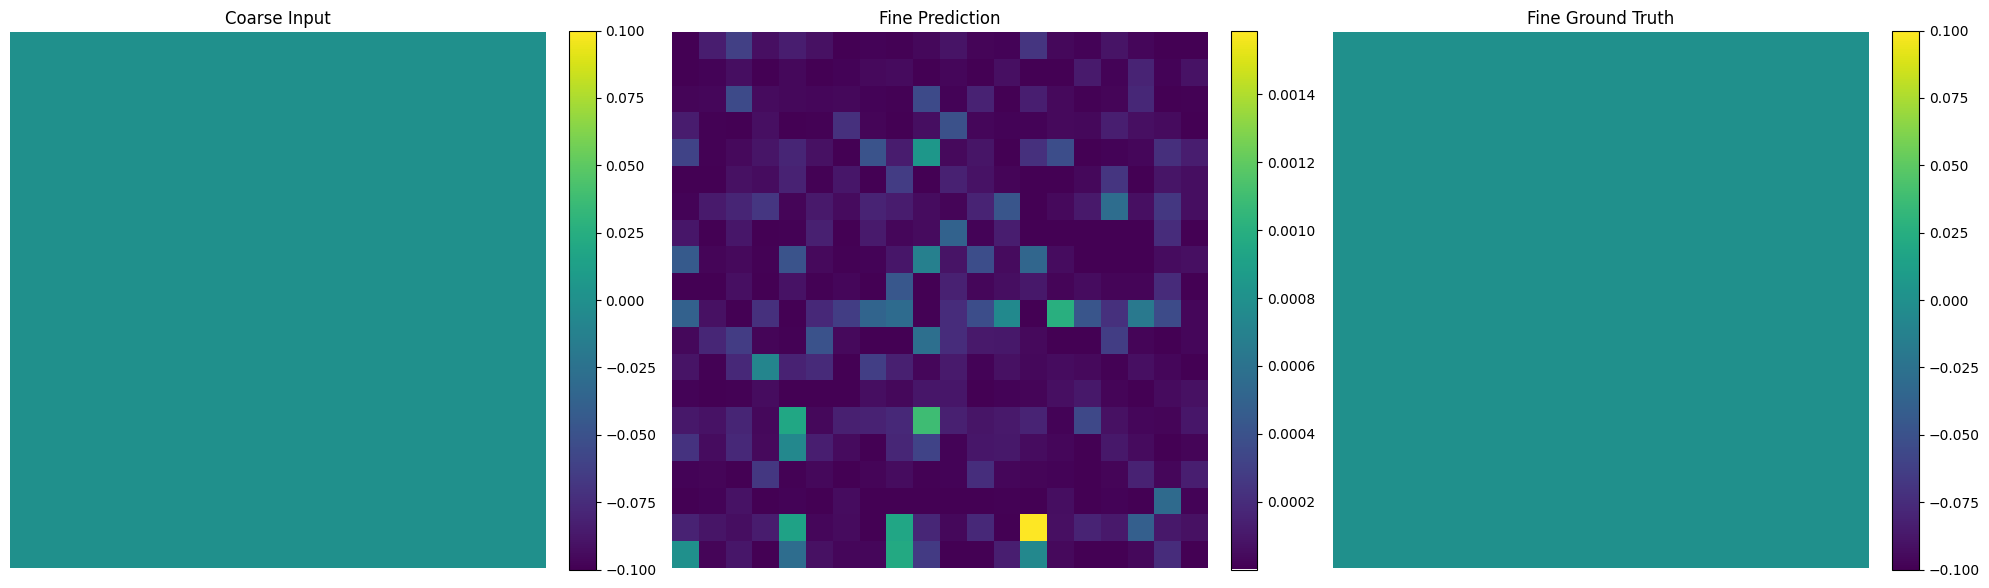

In [67]:
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

def reverse_preprocess(images, original_min, original_max, exp=2):
    # Reverse min-max scaling
    images = images * (original_max - original_min) + original_min
    
    # Reverse exponential root normalization
    images = images ** exp
    
    # Note: We can't reverse the quantile clipping
    return images


def visualize_heatmaps(coarse_input, fine_prediction, fine_ground_truth, index=0):
    """
    Visualize heatmaps for coarse input, fine prediction, and fine ground truth.
    
    :param coarse_input: Coarse-grained input data (shape: [batch, 11, 11, 1])
    :param fine_prediction: Fine-grained prediction (shape: [batch, 22, 22, 1])
    :param fine_ground_truth: Fine-grained ground truth (shape: [batch, 22, 22, 1])
    :param index: Index of the sample to visualize
    """
    # Get original min and max values (you need to store these during preprocessing)
    original_min = np.min(train_ground_truth)
    original_max = np.max(train_ground_truth)

    # Reverse preprocessing
    coarse_input_original = reverse_preprocess(coarse_input, original_min, original_max)
    fine_prediction_original = reverse_preprocess(fine_prediction, original_min, original_max)
    fine_ground_truth_original = reverse_preprocess(fine_ground_truth, original_min, original_max)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Coarse Input
    im1 = ax1.imshow(coarse_input_original[index, :, :, 0], cmap='viridis')
    ax1.set_title('Coarse Input')
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    
    # Fine Prediction
    im2 = ax2.imshow(fine_prediction_original[index, :, :, 0], cmap='viridis')
    ax2.set_title('Fine Prediction')
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
    
    # Fine Ground Truth
    im3 = ax3.imshow(fine_ground_truth_original[index, :, :, 0], cmap='viridis')
    ax3.set_title('Fine Ground Truth')
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Make predictions on the test set
test_predictions = model.predict(x_test)

# Visualize a random sample
random_index = np.random.randint(0, len(x_test))
visualize_heatmaps(x_test, test_predictions, y_test, index=random_index)

# Optionally, you can visualize multiple samples in a loop
num_samples_to_visualize = 5
for i in range(num_samples_to_visualize):
    random_index = np.random.randint(0, len(x_test))
    visualize_heatmaps(x_test, test_predictions, y_test, index=random_index)